In [ ]:
# Loading the required libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

# Data Loading & Inspection

In [3]:
train_data = pd.read_csv('../train_v9rqX0R.csv')
print("Train shape: ",train_data.shape)
display(train_data.head())

Train shape:  (8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
print("Null values in train data:\n",train_data.isnull().sum())

Null values in train data:
 Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


* Two columns have missing values. 

In [4]:
print("train info: ",train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
train info:  None


In [5]:
display(train_data.describe())

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


* Visiblity --> Some items have 0 visiblity. Some items have higher visibility (0.32). Are those outliers?
* Sales --> Highly right-skewed (mean > median, max much larger than Q3), indicating a few items have very high sales.
* Seems no outliers.

In [6]:
categorical_cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier','Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

for col in categorical_cols:
    print("Value counts for :",col)
    print(train_data[col].value_counts())

Value counts for : Item_Identifier
FDG33    10
FDW13    10
DRN47     9
FDF56     9
FDV38     9
         ..
FDY43     1
FDT35     1
FDE52     1
FDN52     1
FDQ60     1
Name: Item_Identifier, Length: 1559, dtype: int64
Value counts for : Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
Value counts for : Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
Value counts for : Outlet_Identifier
OUT027    935
OUT013    932
OUT035    930
OUT049    93

* There are inconsistencies in labeling: 'Low Fat', 'LF', 'low fat', 'Regular' and 'reg'. Should be standardized.

In [7]:
train_data.duplicated().sum()

0

# Data Cleaning

In [8]:
# Standardize 'Item_Fat_Content' values
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

In [9]:
# Handling missing values of Item Weight using Item Identifier feature
train_data['Item_Weight'] = train_data['Item_Weight'].fillna(train_data.groupby('Item_Identifier')['Item_Weight'].transform('mean'))
train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)

# Handling missing values of Outlet Size using Outlet Type, Outlet_Location_Type and Outlet Size features.
train_data['Outlet_Size'] = train_data.groupby(['Outlet_Type','Outlet_Location_Type'])['Outlet_Size']\
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else pd.NA))

train_data.loc[(train_data['Outlet_Size'].isna()) & (train_data['Outlet_Type'] == 'Grocery Store'), 'Outlet_Size'] = 'Small'

In [10]:
train_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

# Exploratory Data Analysis

In [11]:
categorical_cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier','Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
numeric_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP']


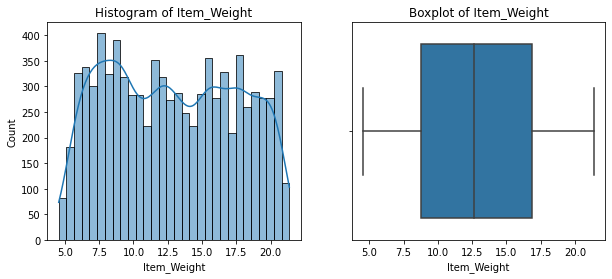

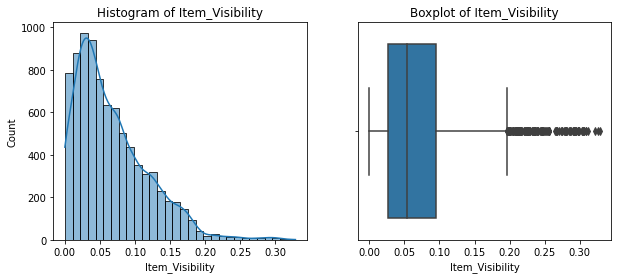

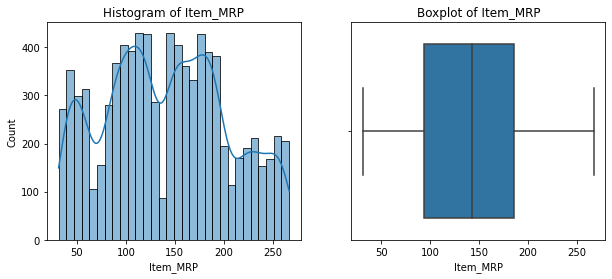

In [ ]:
# Box plan analysis on numeric columns with respect to Item_Outlet_Sales
for col in numeric_cols:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(train_data[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')

    plt.subplot(1,2,2)
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

* Visibility box plot representing --> strong right skewed and the presence of many outliers.(But may not to outliers)

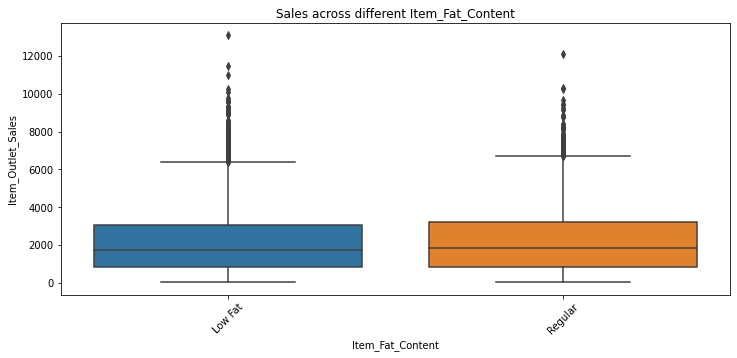

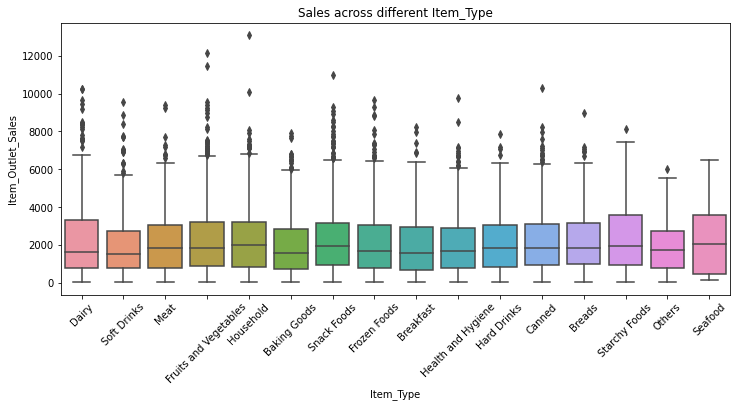

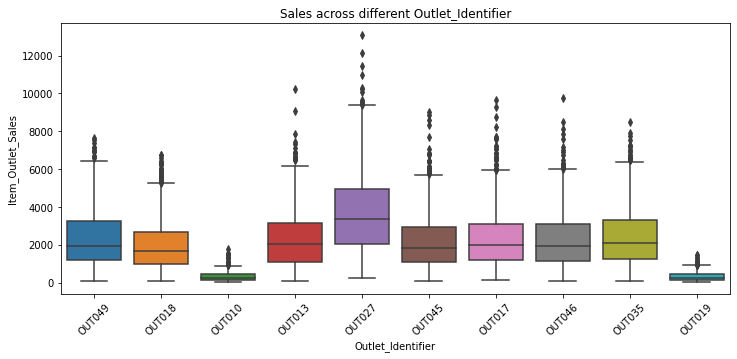

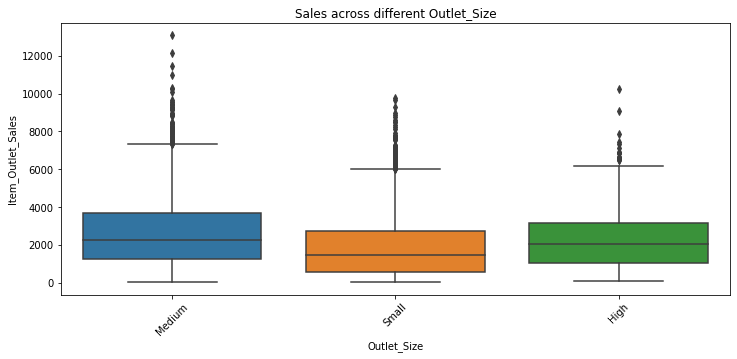

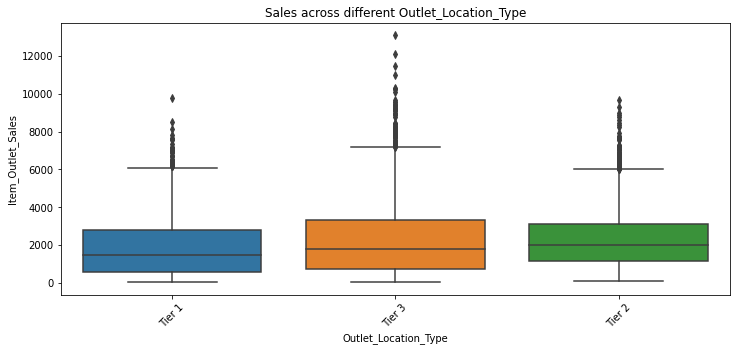

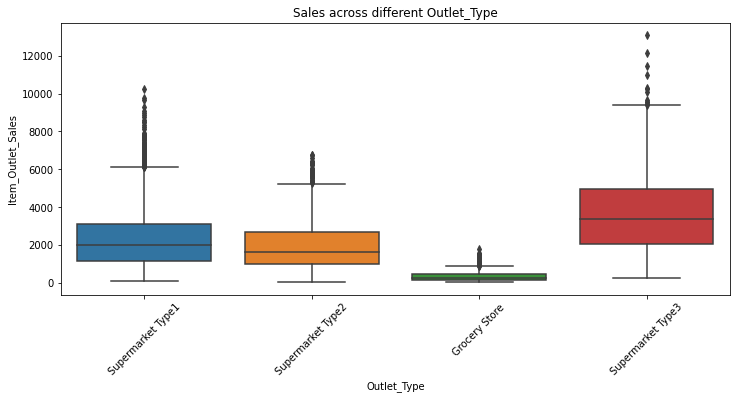

In [13]:
# Box plot analysis on categorical columns with respect to Item_Outlet_Sales
cat_vars_for_sales = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier','Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

# cat_vars_for_sales = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Item_Type']

for col in cat_vars_for_sales:
    plt.figure(figsize=(12,5))
    sns.boxplot(x=train_data[col], y=train_data['Item_Outlet_Sales'])
    plt.title(f'Sales across different {col}')
    plt.xticks(rotation=45)
    plt.show()

*  Outlet_Type and Item_Type are the most influential categorical features for sales prediction.
* Outlet_Size and Outlet_Location_Type also contribute, but to a lesser extent.
* Item_Fat_Content has minimal impact on sales.

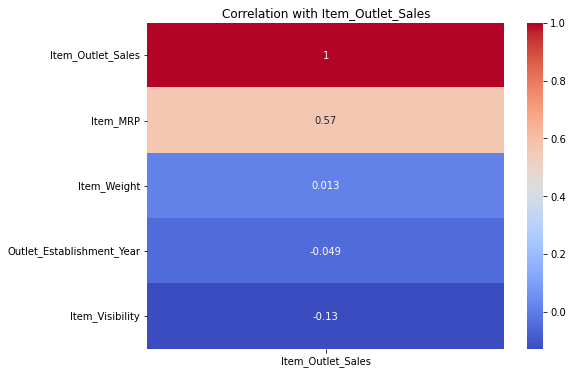

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(train_data.corr()[['Item_Outlet_Sales']].sort_values(by='Item_Outlet_Sales', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Item_Outlet_Sales')
plt.show()

* This plot highlights that Item_MRP is your most predictive numeric variable for sales, while other numeric features have little direct linear impact on the target, at least in this dataset and without feature transformations.
* Unexpected relationships: Weak or negative correlations (like for Item_Visibility)

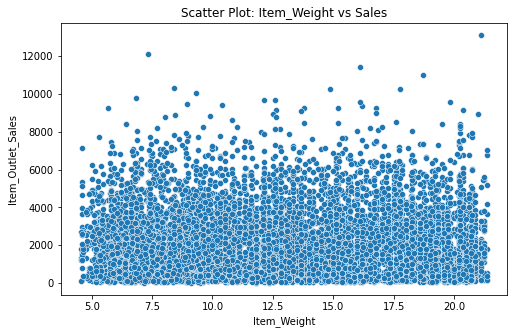

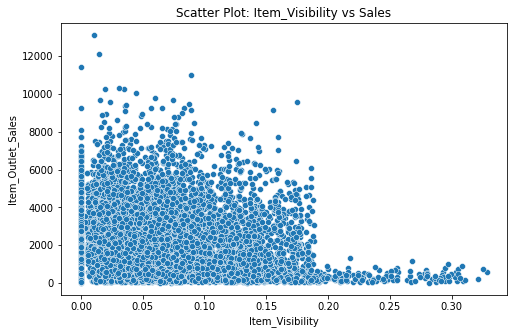

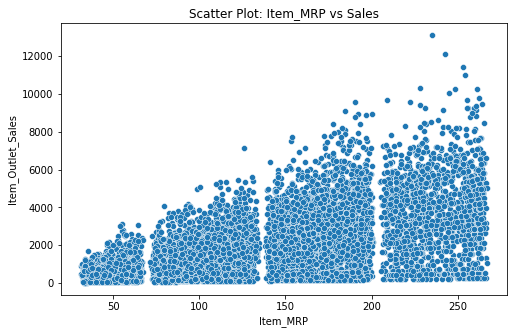

In [15]:
for col in ['Item_Weight', 'Item_Visibility', 'Item_MRP']:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=train_data[col], y=train_data['Item_Outlet_Sales'])
    plt.title(f'Scatter Plot: {col} vs Sales')
    plt.show()

* Item_MRP is positively and strongly related to sales—this feature is highly informative.

* Item_Visibility has a weak or unexpected relationship, with most sales and items at low visibility and little sales presence for high visibility. Needed data handling around it.

# Feature Engineering

In [16]:
import datetime
current_year = datetime.datetime.now().year

# Create Outlet_Age feature
train_data['Outlet_Age'] = current_year - train_data['Outlet_Establishment_Year']

# Making a new categorical feature for Item_Visibility
train_visibility_max = train_data['Item_Visibility'].max()
bins = [ -0.01, 0, 0.05, 0.15, train_visibility_max + 1 ]
labels = ['Zero', 'Low', 'Medium', 'High']
train_data['Item_Visibility'] = pd.cut(train_data['Item_Visibility'], bins=bins, labels=labels)

# Data Preprocesing

In [17]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,Low,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,26
1,DRC01,5.92,Regular,Low,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,16
2,FDN15,17.50,Low Fat,Low,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,26
3,FDX07,19.20,Regular,Zero,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,27
4,NCD19,8.93,Low Fat,Zero,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,38


In [18]:
# Label Encoding
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


df_train = train_data.copy()

# Label Encoding for columns
le_item = LabelEncoder()
le_outlet = LabelEncoder()
le_visibility = LabelEncoder()
le_fat = LabelEncoder()
le_size = LabelEncoder()
le_loc = LabelEncoder()
le_type = LabelEncoder()
le_itype = LabelEncoder()

df_train['Item_Identifier'] = le_item.fit_transform(df_train['Item_Identifier'])
df_train['Outlet_Identifier'] = le_outlet.fit_transform(df_train['Outlet_Identifier'])
df_train['Item_Visibility'] = le_visibility.fit_transform(df_train['Item_Visibility'])
df_train['Item_Fat_Content'] = le_fat.fit_transform(df_train['Item_Fat_Content'])
df_train['Outlet_Size'] = le_size.fit_transform(df_train['Outlet_Size'])
df_train['Outlet_Location_Type'] = le_loc.fit_transform(df_train['Outlet_Location_Type'])
df_train['Outlet_Type'] = le_type.fit_transform(df_train['Outlet_Type'])
df_train['Item_Type'] = le_itype.fit_transform(df_train['Item_Type'])

In [ ]:
from sklearn.preprocessing import StandardScaler

# Fit the scaler on train data only
scaler_mrp = StandardScaler()
scaler_weight = StandardScaler()

df_train['Item_MRP'] = scaler_mrp.fit_transform(df_train[['Item_MRP']])
df_train['Item_Weight'] = scaler_weight.fit_transform(df_train[['Item_Weight']])

# Remove 'Outlet_Establishment_Year' as it's now redundant
data = df_train.drop(columns=['Outlet_Establishment_Year'])

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Splitting the data into training and validation sets
X = data.drop('Item_Outlet_Sales', axis=1)
y = data['Item_Outlet_Sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training a Random Forest Regressor and evaluating with RMSE
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, rf_preds))
print(f"RMSE: {rmse}")

RMSE: 1097.1372935934783


In [22]:
# Hyperparameter Tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=3, scoring='neg_root_mean_squared_error',
                                   n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)
# random_search.fit(X, y)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   23.7s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [23]:
# best parameters and RMSE on validation set
print("Best Parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
rf_preds = best_rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, rf_preds))
print(f"Validation RMSE: {rmse}")

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
Validation RMSE: 1027.2806502271342


In [24]:
# training on the entire dataset with best parameters
best_rf.fit(X, y)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42)

# Results on test data

In [25]:
# Loading and preprocessing the test data
test_data = pd.read_csv('../test_AbJTz2l.csv')

In [ ]:
# Preprocess the test data similarly
# Standardize 'Item_Fat_Content' values
test_data['Item_Fat_Content'] = test_data['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

# Handling missing values of Item Weight using Item Identifier feature
test_data['Item_Weight'] = test_data['Item_Weight'].fillna(test_data.groupby('Item_Identifier')['Item_Weight'].transform('mean'))
test_data['Item_Weight'].fillna(test_data['Item_Weight'].mean(), inplace=True)

test_data['Outlet_Size'] = test_data.groupby(['Outlet_Type','Outlet_Location_Type'])['Outlet_Size']\
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else pd.NA))
test_data.loc[(test_data['Outlet_Size'].isna()) & (test_data['Outlet_Type'] == 'Grocery Store'), 'Outlet_Size'] = 'Small'

# Standardizing numerical features using the same standard scaler fitted on train data
test_data['Item_MRP'] = scaler_mrp.transform(test_data[['Item_MRP']])
test_data['Item_Weight'] = scaler_weight.transform(test_data[['Item_Weight']])


current_year = datetime.datetime.now().year
test_data['Outlet_Age'] = current_year - test_data['Outlet_Establishment_Year']

# Making a new categorical feature for Item_Visibility
bins = [ -0.01, 0, 0.05, 0.15, train_visibility_max + 1 ]
labels = ['Zero', 'Low', 'Medium', 'High']
test_data['Item_Visibility'] = pd.cut(test_data['Item_Visibility'], bins=bins, labels=labels)

# Label Encoding for test data using the same encoders fitted on train data
df_test = test_data.copy()
# Apply same label encoders
df_test['Item_Identifier'] = le_item.transform(df_test['Item_Identifier'])
df_test['Outlet_Identifier'] = le_outlet.transform(df_test['Outlet_Identifier'])
df_test['Item_Visibility'] = le_visibility.transform(df_test['Item_Visibility'])
df_test['Item_Fat_Content'] = le_fat.transform(df_test['Item_Fat_Content'])
df_test['Outlet_Size'] = le_size.transform(df_test['Outlet_Size']) 
df_test['Outlet_Location_Type'] = le_loc.transform(df_test['Outlet_Location_Type'])
df_test['Outlet_Type'] = le_type.transform(df_test['Outlet_Type'])
df_test['Item_Type'] = le_itype.transform(df_test['Item_Type'])

df_test.drop("Outlet_Establishment_Year", axis=1, inplace=True)

In [28]:
df_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age
0,1114,1.695377,0,1,13,-0.532035,9,1,0,1,26
1,1078,-0.985077,1,1,4,-0.861920,2,2,1,1,18
2,1420,0.371298,0,2,11,1.618094,0,2,2,0,27
3,817,-1.197145,0,1,13,0.225484,2,2,1,1,18
4,1197,0.156000,1,2,4,1.497272,5,1,2,3,40


In [ ]:
# Predicting on the test data
df_test['Item_Outlet_Sales_Predicted'] = best_rf.predict(df_test)

# # Rename prediction column to match submission format
submission = df_test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales_Predicted']]
submission.rename(columns={'Item_Outlet_Sales_Predicted': 'Item_Outlet_Sales'}, inplace=True)
# Restore original string IDs for submission
submission['Item_Identifier'] = le_item.inverse_transform(submission['Item_Identifier'])
submission['Outlet_Identifier'] = le_outlet.inverse_transform(submission['Outlet_Identifier'])
# submission['Item_Outlet_Sales'] = submission['Item_Outlet_Sales'].clip(lower=0)

submission.to_csv('bigmart_sales_predictions_rf_final.csv', index=False)


c:\Users\narthu\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-30-c989b49587d9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Identifier'] = le_item.inverse_transform(submission['Item_Identifier'])
<ipython-input-30-c989b49587d9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [31]:
submission.describe()

,Item_Outlet_Sales
count,5681.000000
mean,2181.855615
std,1256.549607
min,113.512833
25%,1184.954036
50%,1960.572758
75%,3027.325642
max,6546.443483
